# Data Wrangling - 311 Data

### Data cleaning steps:
* Imported the City of Minneapolis's 311 data using an API (2017 and 2018 data), and by downloading a csv file (2016 data). (http://opendata.minneapolismn.gov/datasets?t=311)
* Formatted timestamps entries to be datetime values
* Created column called ‘days_open’, which calculates the difference between the opened_date and closed_date columns (in days).
* Set the index as the datetime each case was opened.
* Re-ordered the columns
* Merged the 2016 and 2017 data into one dataframe.
* Imported historical climate data by downloading a csv file from Minnesota's Department of Natural Resources. (https://www.dnr.state.mn.us/climate/historical/summary.html)
* Joined the climate data into the 311 dataframe, matching the date each case was opened.

### Missing values:
* Identified a large cluster of cases which had the same close date. It’s unclear if these close dates are accurate, or were filled in to avoid missing values. These cases will be explored further.
* The weather data contains mostly numerical data, with the exception of “T” entries. This stands for “trace amounts” of precipitation and snow fall. Considering changing “T” to a numeric value such as 0.05 or 0.01 (inches).

### Outliers:
* One case (a parking violation) lists the closed datetime as 3 seconds before it was opened. The ‘days_open’ value was updated to be zero. The case was opened 2017-10-30 08:40:03, id 101004098144.


In [3]:
import requests
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## 311 Data - 2017

In [3]:
# Pull data from API - 311 2017
url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2017/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
r = requests.get(url)
api_json_data = r.json()
data_entries = api_json_data['features']

# Normalize the JSON data to populate tables from nested element
df17 = json_normalize(data_entries)


In [4]:
# Create new column names
new_col_names = ['case_id',
 'status', 'closed_date', 'enquiry_type_id', 'object_id', 'opened_date', 
 'reason', 'subject', 'title', 'type_name', 
 'x_coord', 'y_coord', 'x_geom', 'y_geom']

# Rename columns
df17.columns = new_col_names

# Sort by the unique identifier - opened_date
df17 = df17.sort_values(by = 'opened_date')


In [5]:
# Convert 'opened_date' values to datetime objects
df17['opened_date'] = df17['opened_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat())

# Convert 'closed_date' values to datetime objects, unless NaN
df17['closed_date'] = df17['closed_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat() 
                                               if pd.notnull(x) else x)

In [6]:
# Function to calculate the number of days between when each case was opened and closed.
def days_open(row):
    datetimeFormat = '%Y-%m-%dT%H:%M:%S'
    if pd.notnull(row['closed_date']):
        date_cl = row['closed_date']
        date_op = row['opened_date']
        diff = datetime.strptime(date_cl, datetimeFormat)\
            - datetime.strptime(date_op, datetimeFormat)
        return diff.days
    else:
        return np.nan

In [7]:
# Create new column that lists the number of days each case was open.
df17['days_open'] = df17.apply(lambda row: days_open(row), axis=1)


In [8]:
df17.head()

,case_id,status,closed_date,enquiry_type_id,object_id,opened_date,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
28842,101003980487,0,2017-01-01T07:01:08,101002281,28843,2016-12-31T19:22:11,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038507e+07,5.613839e+06,-93.290629,44.951182,0.0
28610,101003980490,0,2017-01-04T09:14:40,101000108,28611,2017-01-01T03:34:49,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.038661e+07,5.618705e+06,-93.304515,44.982106,3.0
28843,101003980492,0,2017-01-01T06:58:19,101002281,28844,2017-01-01T05:00:31,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038039e+07,5.620891e+06,-93.248613,44.995997,0.0
28844,101003980493,0,2017-01-01T06:23:32,101002281,28845,2017-01-01T05:26:03,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.037926e+07,5.618823e+06,-93.238468,44.982858,0.0
27143,101003980494,0,2017-01-04T12:39:50,101002221,27144,2017-01-01T06:38:05,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038154e+07,5.615371e+06,-93.258925,44.960918,3.0


In [9]:
# Convert dates to pandas datetime format.
df17['opened_date'] = pd.to_datetime(df17['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df17['closed_date'] = pd.to_datetime(df17['closed_date'], format='%Y-%m-%dT%H:%M:%S')

# Set the opened date as the index.
df17 = df17.set_index('opened_date')
df17.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2016-12-31 19:22:11,101003980487,0,2017-01-01 07:01:08,101002281,28843,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038507e+07,5.613839e+06,-93.290629,44.951182,0.0
2017-01-01 03:34:49,101003980490,0,2017-01-04 09:14:40,101000108,28611,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.038661e+07,5.618705e+06,-93.304515,44.982106,3.0
2017-01-01 05:00:31,101003980492,0,2017-01-01 06:58:19,101002281,28844,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038039e+07,5.620891e+06,-93.248613,44.995997,0.0
2017-01-01 05:26:03,101003980493,0,2017-01-01 06:23:32,101002281,28845,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.037926e+07,5.618823e+06,-93.238468,44.982858,0.0
2017-01-01 06:38:05,101003980494,0,2017-01-04 12:39:50,101002221,27144,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038154e+07,5.615371e+06,-93.258925,44.960918,3.0


## 311 Data - 2016

In [9]:
# Pull data from API - 311 2017
#url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2016/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
#r = requests.get(url)
#api_json_data = r.json()

#data_entries = api_json_data['features']
#df16 = json_normalize(data_entries)
#df16.info()

#api_json_data.keys()
#what_happened = api_json_data['exceededTransferLimit'] #true
#what_happened

The API for 2016 data returned only 1000 out of 51k rows. The 'exceededTransferLimit' line of the data was listed as "True". As an alternative, the data was downloaded as a CSV file.

In [11]:
df16 = pd.read_csv("311_Incidents_2016.csv")
df16.head()

,X,Y,CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,LastUpdateDate,OBJECTID
0,-93.235927,44.931412,101003863139,101000085,Streets,Street Maintenance,General Street Complaint,General Street Complaint,2016-03-18T08:54:34.000Z,0,2016-03-21T06:57:34.000Z,-1.037898e+07,5.610730e+06,2018-03-13T10:24:55.000Z,3001
1,-93.255669,44.988227,101003863146,101002181,Public Safety,Graffiti / Clean City,Graffiti - Open311,Graffiti - Open311,2016-03-18T09:02:08.000Z,0,2016-03-23T09:37:03.000Z,-1.038117e+07,5.619668e+06,2018-03-13T10:24:55.000Z,3002
2,-93.291268,44.950040,101003863162,101002181,Public Safety,Graffiti / Clean City,Graffiti - Open311,Graffiti - Open311,2016-03-18T09:32:10.000Z,0,2016-03-25T09:39:59.000Z,-1.038514e+07,5.613660e+06,2018-03-13T10:24:55.000Z,3003
3,-93.291268,44.950040,101003863163,101002181,Public Safety,Graffiti / Clean City,Graffiti - Open311,Graffiti - Open311,2016-03-18T09:32:10.000Z,0,2016-03-25T09:41:21.000Z,-1.038514e+07,5.613660e+06,2018-03-13T10:24:55.000Z,3004
4,0.000000,-0.000000,101003863180,101000172,Property,Private Property,Residential Conditions Complaint HOD Tenant,Residential Conditions Complaint HOD Tenant,2016-03-18T09:58:28.000Z,0,2016-03-22T19:36:03.000Z,0.000000e+00,0.000000e+00,2018-03-13T10:24:55.000Z,3005


In [12]:
# Standardize column names
new_col_names = [ 'x_geom', 'y_geom', 'case_id', 'enquiry_type_id',
                 'subject', 'reason', 'type_name', 'title',
                 'opened_date', 'status', 'closed_date', 
                 'x_coord', 'y_coord', 'last_update', 'object_id']

df16.columns = new_col_names
df16 = df16.sort_values(by = 'opened_date')


In [13]:
# The CSV file contains different date formatting than the API and JSON file.
# Thus, the days_open function was updated with new date formats.

def days_open_csv(row):
    datetimeFormat = '%Y-%m-%dT%H:%M:%S.%fZ'
    if pd.notnull(row['closed_date']):
        date_cl = row['closed_date']
        date_op = row['opened_date']
        diff = datetime.strptime(date_cl, datetimeFormat)\
            - datetime.strptime(date_op, datetimeFormat)
        return diff.days
    else:
        return np.nan

In [14]:
# Add column that lists the number of days until each case was closed.
df16['days_open'] = df16.apply(lambda row: days_open_csv(row), axis=1)


In [14]:
df16.head()


,x_geom,y_geom,case_id,enquiry_type_id,subject,reason,type_name,title,opened_date,status,closed_date,x_coord,y_coord,last_update,object_id,days_open
3195,-93.259481,44.950087,101003839191,101002221,Vehicles and Commuting,Traffic Control,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,2016-01-01T00:10:35.000Z,0,2016-01-02T12:03:41.000Z,-1.038160e+07,5.613667e+06,2018-03-13T10:24:54.000Z,2196,1
20549,-93.291802,44.965918,101003839192,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,2016-01-01T07:50:34.000Z,0,2016-01-02T09:08:54.000Z,-1.038520e+07,5.616158e+06,2018-03-13T10:24:54.000Z,29550,1
12632,-93.235196,45.024063,101003839193,101001081,Sidewalks,Snow & Ice,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,2016-01-01T08:46:35.000Z,0,2016-02-08T11:28:20.000Z,-1.037889e+07,5.625311e+06,2018-03-13T10:24:54.000Z,19633,38
12633,-93.290172,44.892400,101003839194,101000093,Vehicles and Commuting,Traffic Control,Parking Violation Complaint,Parking Violation Complaint,2016-01-01T09:35:17.000Z,0,2016-01-04T09:30:00.000Z,-1.038501e+07,5.604598e+06,2018-03-13T10:24:54.000Z,19634,2
3196,-93.276582,44.964583,101003839195,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,2016-01-01T10:00:34.000Z,0,2016-01-02T09:37:55.000Z,-1.038350e+07,5.615948e+06,2018-03-13T10:24:54.000Z,2197,0


In [15]:
# Convert dates to pandas datetime format.
df16['opened_date'] = pd.to_datetime(df16['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df16['closed_date'] = pd.to_datetime(df16['closed_date'], format='%Y-%m-%dT%H:%M:%S')

# Set the opened date as the index.
df16 = df16.set_index('opened_date')
df16.head()

,x_geom,y_geom,case_id,enquiry_type_id,subject,reason,type_name,title,status,closed_date,x_coord,y_coord,last_update,object_id,days_open
opened_date,,,,,,,,,,,,,,,
2016-01-01 00:10:35,-93.259481,44.950087,101003839191,101002221,Vehicles and Commuting,Traffic Control,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,0,2016-01-02 12:03:41,-1.038160e+07,5.613667e+06,2018-03-13T10:24:54.000Z,2196,1
2016-01-01 07:50:34,-93.291802,44.965918,101003839192,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,0,2016-01-02 09:08:54,-1.038520e+07,5.616158e+06,2018-03-13T10:24:54.000Z,29550,1
2016-01-01 08:46:35,-93.235196,45.024063,101003839193,101001081,Sidewalks,Snow & Ice,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,0,2016-02-08 11:28:20,-1.037889e+07,5.625311e+06,2018-03-13T10:24:54.000Z,19633,38
2016-01-01 09:35:17,-93.290172,44.892400,101003839194,101000093,Vehicles and Commuting,Traffic Control,Parking Violation Complaint,Parking Violation Complaint,0,2016-01-04 09:30:00,-1.038501e+07,5.604598e+06,2018-03-13T10:24:54.000Z,19634,2
2016-01-01 10:00:34,-93.276582,44.964583,101003839195,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,0,2016-01-02 09:37:55,-1.038350e+07,5.615948e+06,2018-03-13T10:24:54.000Z,2197,0


In [16]:
# Re-order the columns to align with the 2017 dataframe.
# The unnecessary "last_update" column is also removed.

df16 = df16[list(df17.columns)]
df16.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2016-01-01 00:10:35,101003839191,0,2016-01-02 12:03:41,101002221,2196,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038160e+07,5.613667e+06,-93.259481,44.950087,1
2016-01-01 07:50:34,101003839192,0,2016-01-02 09:08:54,101002281,29550,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038520e+07,5.616158e+06,-93.291802,44.965918,1
2016-01-01 08:46:35,101003839193,0,2016-02-08 11:28:20,101001081,19633,Snow & Ice,Sidewalks,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,-1.037889e+07,5.625311e+06,-93.235196,45.024063,38
2016-01-01 09:35:17,101003839194,0,2016-01-04 09:30:00,101000093,19634,Traffic Control,Vehicles and Commuting,Parking Violation Complaint,Parking Violation Complaint,-1.038501e+07,5.604598e+06,-93.290172,44.892400,2
2016-01-01 10:00:34,101003839195,0,2016-01-02 09:37:55,101002281,2197,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038350e+07,5.615948e+06,-93.276582,44.964583,0


In [17]:
# Combine 2016 and 2017 call data
df1617 = df16.append(df17)

df1617.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106928 entries, 2016-01-01 00:10:35 to 2017-12-31 06:56:54
Data columns (total 14 columns):
case_id            106928 non-null int64
status             106928 non-null int64
closed_date        106325 non-null datetime64[ns]
enquiry_type_id    106928 non-null int64
object_id          106928 non-null int64
reason             106928 non-null object
subject            106928 non-null object
title              106928 non-null object
type_name          106928 non-null object
x_coord            106928 non-null float64
y_coord            106928 non-null float64
x_geom             106928 non-null float64
y_geom             106928 non-null float64
days_open          106325 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 12.2+ MB


## Search for Missing Values

In [18]:
df1617.closed_date.value_counts(dropna=False).head(20)

NaT                    603
2018-01-29 07:41:25    100
2018-01-29 07:39:05    100
2017-03-31 08:45:18     95
2018-01-29 07:36:39     95
2018-01-29 08:26:09     91
2017-03-31 13:45:55     91
2017-10-31 12:34:48     84
2017-03-31 13:47:49     68
2018-01-29 07:46:29     64
2018-01-29 08:27:21     63
2017-10-31 12:34:49     60
2017-10-31 12:34:47     55
2018-01-29 08:55:44     55
2018-01-29 08:53:38     29
2017-10-31 17:34:48     23
2017-10-31 17:34:47     18
2017-10-31 17:34:49     17
2017-06-12 03:03:54     10
2017-06-12 02:54:32      9
Name: closed_date, dtype: int64

1. The 603 missing values are cases that are still open. No close date is expected.
2. Why were so many cases closed on 2018-01-29 and 2017-03-31? Are they a group of cases?

## Search for Outliers

In [19]:
df1617.describe()

,case_id,status,enquiry_type_id,object_id,x_coord,y_coord,x_geom,y_geom,days_open
count,1.069280e+05,106928.000000,1.069280e+05,106928.000000,1.069280e+05,1.069280e+05,1.069280e+05,1.069280e+05,106325.000000
mean,1.010040e+11,0.005639,1.010008e+08,26759.527533,-9.607225e+06,5.196746e+06,-8.630317e+01,4.160782e+01,10.259149
std,8.086110e+04,0.074884,1.010961e+03,15480.518465,2.729446e+06,1.476424e+06,2.451903e+01,1.182098e+01,31.301559
min,1.010038e+11,0.000000,1.010000e+08,1.000000,-1.038935e+07,0.000000e+00,-9.332915e+01,-1.280796e-14,-1.000000
25%,1.010039e+11,0.000000,1.010001e+08,13366.750000,-1.038512e+07,5.610720e+06,-9.329116e+01,4.493135e+01,0.000000
50%,1.010040e+11,0.000000,1.010002e+08,26732.500000,-1.038250e+07,5.614949e+06,-9.326761e+01,4.495823e+01,2.000000
75%,1.010041e+11,0.000000,1.010011e+08,40098.250000,-1.037922e+07,5.620285e+06,-9.323808e+01,4.499214e+01,6.000000
max,1.010041e+11,1.000000,1.010038e+08,55164.000000,0.000000e+00,5.629593e+06,2.544444e-14,4.505124e+01,549.000000


In [18]:
# Inspect case(s) open for -1 days. 
df1617[df1617['days_open'] == -1.0] 

# Note: case was closed 3 seconds before it was opened.

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2017-10-30 08:40:03,101004098144,0,2017-10-30 08:40:00,101000093,46556,Traffic Control,Vehicles and Commuting,Parking Violation Complaint,Parking Violation Complaint,-1.037889e+07,5.613397e+06,-93.235147,44.948372,-1.0


In [19]:
# Replace -1 value in 'days_open' column with 0.
df1617.days_open = df1617.days_open.replace(-1.0, 0.0) 

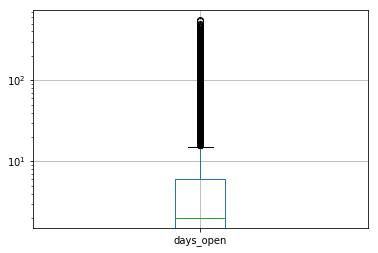

In [24]:
# View box plot of number of days open, to visually inspect outliers
df1617.boxplot(column='days_open')
plt.yscale('log')
#plt.savefig('days_open_boxplot.png')
plt.show()

#### Outliers
The 75th percentile is 6 days, for number of days each case is open. This implies any case open longer than a week is an outlier. This will need to be examined for each type of case.

## 311 Data - 2018

This data is updated daily, and will be kept separate from the 2016 and 2017 data.

In [25]:
url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2018_YTD/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
r = requests.get(url)
api_json_data = r.json()

data_entries = api_json_data['features']
df18 = json_normalize(data_entries)

# Standardize column names 
new_col_names = ['case_id', 'status', 'closed_date', 'enquiry_type_id', 'object_id', 
                 'opened_date', 'reason', 'subject', 'title', 'type_name', 
                 'x_coord', 'y_coord', 'x_geom', 'y_geom']
df18.columns = new_col_names

In [24]:
# Convert 'OpenDateTime' values to datetime objects
df18['opened_date'] = df18['opened_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat())
# Convert 'CloseDateTime' values to datetime objects, unless NaN
df18['closed_date'] = df18['closed_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat() 
                                               if pd.notnull(x) else x)
df18['days_open'] = df18.apply(lambda row: days_open(row), axis=1)

In [25]:
# Convert dates to pandas datetime format.
df18['opened_date'] = pd.to_datetime(df18['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df18['closed_date'] = pd.to_datetime(df18['closed_date'], format='%Y-%m-%dT%H:%M:%S')

# Sort by opened_date
df18 = df18.sort_values(by = 'opened_date')

# Set the opened date as the index.
df18 = df18.set_index('opened_date')
df18.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2017-12-31 18:05:00,101004120778,0,2018-01-02 02:38:36,101002181,23342,Graffiti / Clean City,Public Safety,Graffiti - Open311,Graffiti - Open311,-1.038604e+07,5.608372e+06,-93.299350,44.916415,1.0
2017-12-31 21:37:13,101004120779,0,2018-01-01 13:26:45,101002281,23344,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038293e+07,5.614953e+06,-93.271489,44.958263,0.0
2018-01-01 03:58:42,101004120781,0,2018-01-10 18:58:21,101000108,38167,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.037949e+07,5.611866e+06,-93.240585,44.938632,9.0
2018-01-01 04:05:00,101004120782,0,2018-01-01 14:06:33,101002281,26286,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.037665e+07,5.616573e+06,-93.215065,44.968555,0.0
2018-01-01 04:13:21,101004120783,0,2018-01-02 02:34:11,101000022,38168,Street Maintenance,Streets,Pothole,Pothole,-1.038766e+07,5.621619e+06,-93.313969,45.000618,0.0


In [26]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38473 entries, 2017-12-31 18:05:00 to 2018-07-27 14:44:00
Data columns (total 14 columns):
case_id            38473 non-null int64
status             38473 non-null int64
closed_date        36347 non-null datetime64[ns]
enquiry_type_id    38473 non-null int64
object_id          38473 non-null int64
reason             38473 non-null object
subject            38473 non-null object
title              38473 non-null object
type_name          38473 non-null object
x_coord            38473 non-null float64
y_coord            38473 non-null float64
x_geom             38473 non-null float64
y_geom             38473 non-null float64
days_open          36347 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 4.4+ MB


## Climate data - 2017
Historical climate data from the State of Minnesota. Columns include:
* Maximum Temperature (F)
* Minimum Temperature (F)
* Precipitation (Inches)
* Snow Fall (Inches)
* Snow Depth (Inches)

In [6]:
df_weather = pd.read_csv("Climate_Data_16_17.csv", index_col = 'Date', parse_dates = True)

# Standardize column names 
new_col_names = ['max_temp', 'min_temp', 'precipitation', 'snow', 'snow_depth']
df_weather.columns = new_col_names

df_weather.head()  # T = trace amounts

,max_temp,min_temp,precipitation,snow,snow_depth
Date,,,,,
2016-01-01,30,15,T,T,4
2016-01-02,31,14,0,0,4
2016-01-03,29,20,0,0,4
2016-01-04,26,10,0,0,4
2016-01-05,32,20,0,0,4


In [69]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 933 entries, 2016-01-01 to 2018-07-21
Data columns (total 5 columns):
max_temp         933 non-null int64
min_temp         933 non-null int64
precipitation    933 non-null object
snow             933 non-null object
snow_depth       933 non-null object
dtypes: int64(2), object(3)
memory usage: 43.7+ KB


In [27]:
df_weather['precipitation'].value_counts(dropna=False).head(10)

0       474
T       147
0.01     43
0.02     21
0.04     16
0.05     13
0.08     12
0.07     12
0.03     11
0.09      8
Name: precipitation, dtype: int64

In [28]:
df_weather['snow'].value_counts(dropna=False).head(10)

0      763
T       86
0.1     14
0.3      8
0.6      7
0.4      5
0.5      4
0.2      4
0.7      3
2.1      3
Name: snow, dtype: int64

In [29]:
df_weather['snow_depth'].value_counts(dropna=False).head(10)

0    658
2     62
1     46
T     43
5     42
3     26
4     23
6     11
7      8
9      5
Name: snow_depth, dtype: int64

In [7]:
# Some precipitation, snow, and snow depth entries are "T" for "trace amounts".
# Current minimum values in each column are 0.01 inches (precipitation, snow) and 0.1 inches (snow depth).
# Replace these "T" values with a half increment.

df_weather.precipitation = df_weather.precipitation.replace('T', 0.005)
df_weather.snow = df_weather.snow.replace('T', 0.005)
df_weather.snow_depth = df_weather.snow_depth.replace('T', 0.05)

# Coerce the values into numeric types, after removing any string values.

df_weather.precipitation = pd.to_numeric(df_weather.precipitation)
df_weather.snow = pd.to_numeric(df_weather.snow)
df_weather.snow_depth = pd.to_numeric(df_weather.snow_depth)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 933 entries, 2016-01-01 to 2018-07-21
Data columns (total 5 columns):
max_temp         933 non-null int64
min_temp         933 non-null int64
precipitation    933 non-null float64
snow             933 non-null float64
snow_depth       933 non-null float64
dtypes: float64(3), int64(2)
memory usage: 43.7 KB


In [8]:
df_weather.describe()

,max_temp,min_temp,precipitation,snow,snow_depth
count,933.000000,933.000000,933.000000,933.000000,933.000000
mean,56.556270,39.757771,0.097208,0.142369,0.858682
std,23.756777,21.887178,0.269279,0.822557,1.856775
min,-6.000000,-20.000000,0.000000,0.000000,0.000000
25%,37.000000,24.000000,0.000000,0.000000,0.000000
50%,60.000000,42.000000,0.000000,0.000000,0.000000
75%,78.000000,60.000000,0.040000,0.000000,0.050000
max,100.000000,77.000000,2.180000,12.400000,11.000000


## Combine 311 and climate dataframes
* Separate the date and time values from the opened_date index. These will be saved in new columns called 'open_day' and 'open_time'.
* Use multi indexing to isolate the date each case was opened.
* Merge the climate data and 311 data by matching the opened date.

In [32]:
# Need to create date column in order to combine with weather data.
df1617['open_day'] = df1617.index.date
df1617['open_time'] = df1617.index.time
df1617.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open,open_day,open_time
opened_date,,,,,,,,,,,,,,,,
2016-01-01 00:10:35,101003839191,0,2016-01-02 12:03:41,101002221,2196,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038160e+07,5.613667e+06,-93.259481,44.950087,1.0,2016-01-01,00:10:35
2016-01-01 07:50:34,101003839192,0,2016-01-02 09:08:54,101002281,29550,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038520e+07,5.616158e+06,-93.291802,44.965918,1.0,2016-01-01,07:50:34
2016-01-01 08:46:35,101003839193,0,2016-02-08 11:28:20,101001081,19633,Snow & Ice,Sidewalks,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,-1.037889e+07,5.625311e+06,-93.235196,45.024063,38.0,2016-01-01,08:46:35
2016-01-01 09:35:17,101003839194,0,2016-01-04 09:30:00,101000093,19634,Traffic Control,Vehicles and Commuting,Parking Violation Complaint,Parking Violation Complaint,-1.038501e+07,5.604598e+06,-93.290172,44.892400,2.0,2016-01-01,09:35:17
2016-01-01 10:00:34,101003839195,0,2016-01-02 09:37:55,101002281,2197,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038350e+07,5.615948e+06,-93.276582,44.964583,0.0,2016-01-01,10:00:34


In [33]:
#df1617.index = pd.MultiIndex.from_arrays([df1617.index.date, df1617.index.time], names=['Date','Time'])
df1617.index = pd.MultiIndex.from_arrays([df1617.index.date, df1617.index.time], names=['Date','Time'])


In [34]:
df1617weather = pd.merge(df1617, df_weather, left_index=True, right_index=True, how = 'left')
df1617weather.head()

case_id  status         closed_date  \
Date       Time                                                 
2016-01-01 00:10:35  101003839191       0 2016-01-02 12:03:41   
           07:50:34  101003839192       0 2016-01-02 09:08:54   
           08:46:35  101003839193       0 2016-02-08 11:28:20   
           09:35:17  101003839194       0 2016-01-04 09:30:00   
           10:00:34  101003839195       0 2016-01-02 09:37:55   

                     enquiry_type_id  object_id           reason  \
Date       Time                                                    
2016-01-01 00:10:35        101002221       2196  Traffic Control   
           07:50:34        101002281      29550  Traffic Control   
           08:46:35        101001081      19633       Snow & Ice   
           09:35:17        101000093      19634  Traffic Control   
           10:00:34        101002281       2197  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   
           08:46:35               Sidewalks   Sidewalk Snow and Ice - SS   
           09:35:17  Vehicles and Commuting  Parking Violation Complaint   
           10:00:34  Vehicles and Commuting  Parking Violation - Open311   

                                       type_name       x_coord     ...      \
Date       Time                                                    ...       
2016-01-01 00:10:35  Abandoned Vehicle - Open311 -1.038160e+07     ...       
           07:50:34  Parking Violation - Open311 -1.038520e+07     ...       
           08:46:35   Sidewalk Snow and Ice - SS -1.037889e+07     ...       
           09:35:17  Parking Violation Complaint -1.038501e+07     ...       
           10:00:34  Parking Violation - Open311 -1.038350e+07     ...       

                        x_geom     y_geom  days_open    open_day open_time  \
Date       Time                                                              
2016-01-01 00:10:35 -93.259481  44.950087        1.0  2016-01-01  00:10:35   
           07:50:34 -93.291802  44.965918        1.0  2016-01-01  07:50:34   
           08:46:35 -93.235196  45.024063       38.0  2016-01-01  08:46:35   
           09:35:17 -93.290172  44.892400        2.0  2016-01-01  09:35:17   
           10:00:34 -93.276582  44.964583        0.0  2016-01-01  10:00:34   

                    max_temp  min_temp  precipitation   snow  snow_depth  
Date       Time                                                           
2016-01-01 00:10:35       30        15          0.005  0.005         4.0  
           07:50:34       30        15          0.005  0.005         4.0  
           08:46:35       30        15          0.005  0.005         4.0  
           09:35:17       30        15          0.005  0.005         4.0  
           10:00:34       30        15          0.005  0.005         4.0  

[5 rows x 21 columns]

In [83]:
df1617weather.to_csv('311_clean.csv')

## EDA

In [4]:
# Read the csv data file from above.
df = pd.read_csv('311_clean.csv', index_col=[0,1], parse_dates = ['Date', 'closed_date', 'open_date'])
df.head()

case_id  status         closed_date  \
Date       Time                                                 
2016-01-01 00:10:35  101003839191       0 2016-01-02 12:03:41   
           07:50:34  101003839192       0 2016-01-02 09:08:54   
           08:46:35  101003839193       0 2016-02-08 11:28:20   
           09:35:17  101003839194       0 2016-01-04 09:30:00   
           10:00:34  101003839195       0 2016-01-02 09:37:55   

                     enquiry_type_id  object_id           reason  \
Date       Time                                                    
2016-01-01 00:10:35        101002221       2196  Traffic Control   
           07:50:34        101002281      29550  Traffic Control   
           08:46:35        101001081      19633       Snow & Ice   
           09:35:17        101000093      19634  Traffic Control   
           10:00:34        101002281       2197  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   
           08:46:35               Sidewalks   Sidewalk Snow and Ice - SS   
           09:35:17  Vehicles and Commuting  Parking Violation Complaint   
           10:00:34  Vehicles and Commuting  Parking Violation - Open311   

                                       type_name       x_coord     ...      \
Date       Time                                                    ...       
2016-01-01 00:10:35  Abandoned Vehicle - Open311 -1.038160e+07     ...       
           07:50:34  Parking Violation - Open311 -1.038520e+07     ...       
           08:46:35   Sidewalk Snow and Ice - SS -1.037889e+07     ...       
           09:35:17  Parking Violation Complaint -1.038501e+07     ...       
           10:00:34  Parking Violation - Open311 -1.038350e+07     ...       

                        x_geom     y_geom  days_open  open_date open_time  \
Date       Time                                                             
2016-01-01 00:10:35 -93.259481  44.950087        1.0 2016-01-01  00:10:35   
           07:50:34 -93.291802  44.965918        1.0 2016-01-01  07:50:34   
           08:46:35 -93.235196  45.024063       38.0 2016-01-01  08:46:35   
           09:35:17 -93.290172  44.892400        2.0 2016-01-01  09:35:17   
           10:00:34 -93.276582  44.964583        0.0 2016-01-01  10:00:34   

                    max_temp  min_temp  precipitation   snow  snow_depth  
Date       Time                                                           
2016-01-01 00:10:35       30        15          0.005  0.005         4.0  
           07:50:34       30        15          0.005  0.005         4.0  
           08:46:35       30        15          0.005  0.005         4.0  
           09:35:17       30        15          0.005  0.005         4.0  
           10:00:34       30        15          0.005  0.005         4.0  

[5 rows x 21 columns]

### Simplifying the dataframe
* Remove unnecessary columns
* Count unique values in each column to determine if they can be grouped or converted to numeric placeholders.

In [28]:
cols = list(df.columns)
#cols

In [27]:
# Number of unique entries per column
unique_counts = {col : df[col].nunique() for col in cols}
unique_counts

{'case_id': 106927,
 'status': 2,
 'closed_date': 104453,
 'enquiry_type_id': 97,
 'object_id': 55164,
 'reason': 27,
 'subject': 10,
 'title': 97,
 'type_name': 97,
 'x_coord': 11285,
 'y_coord': 11355,
 'x_geom': 12763,
 'y_geom': 12375,
 'days_open': 383,
 'open_date': 731,
 'open_time': 49350,
 'max_temp': 99,
 'min_temp': 90,
 'precipitation': 82,
 'snow': 24,
 'snow_depth': 11}

In [13]:
print(df.reason.nunique(), ": ", df.reason.unique())

27 :  ['Traffic Control' 'Snow & Ice' 'Graffiti / Clean City' 'Animal Control'
 'Complaints' 'Private Property' 'Street Maintenance'
 'Commercial / Business Licensing' 'Unhealthy Conditions' 'Water'
 'Parking' 'Traffic' 'Garbage & Recycling' 'Construction Inspections'
 'Lighting' 'Biking' 'Sewer & Storm Drain' 'Zoning' 'Inspection'
 'Street Cleaning / Sweeping' 'Fire' 'Police' 'Commercial Property'
 'Traffic Safety' 'Truth in Sale of Housing' 'Green Spaces - Public'
 'Bridges']


In [62]:
print(df.subject.nunique(), ": ", df.subject.unique())

10 :  ['Vehicles and Commuting' 'Sidewalks' 'Public Safety' 'Animal Related'
 'Streets' 'Property' 'Permits / Licensing' 'Health / Environmental'
 'Utilities Related' 'Solid Waste & Recycling']


In [36]:
# Check whether title and type_name are identical.
list(df.title) == list(df.type_name)

True

In [5]:
#df.title.unique()
df.title.value_counts(dropna=False).head()

Abandoned Vehicle                 14585
Parking Violation Complaint       11895
Exterior Nuisance Complaint        9536
Animal Complaint - Livability      8288
Graffiti complaint / reporting     6495
Name: title, dtype: int64

In [132]:
# Reorder and remove unused columns ('case_id', 'type_name', 'open_date', 'open_time')
df = df[['status', 'closed_date', 'days_open', 'reason', 'subject', 'title', 'enquiry_type_id',
       'x_coord', 'y_coord', 'x_geom', 'y_geom', 'object_id', 
       'max_temp', 'min_temp', 'precipitation', 'snow', 'snow_depth']]

In [77]:
df.head()

status         closed_date  days_open           reason  \
Date       Time                                                               
2016-01-01 00:10:35       0 2016-01-02 12:03:41        1.0  Traffic Control   
           07:50:34       0 2016-01-02 09:08:54        1.0  Traffic Control   
           08:46:35       0 2016-02-08 11:28:20       38.0       Snow & Ice   
           09:35:17       0 2016-01-04 09:30:00        2.0  Traffic Control   
           10:00:34       0 2016-01-02 09:37:55        0.0  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   
           08:46:35               Sidewalks   Sidewalk Snow and Ice - SS   
           09:35:17  Vehicles and Commuting  Parking Violation Complaint   
           10:00:34  Vehicles and Commuting  Parking Violation - Open311   

                     enquiry_type_id       x_coord       y_coord     x_geom  \
Date       Time                                                               
2016-01-01 00:10:35        101002221 -1.038160e+07  5.613667e+06 -93.259481   
           07:50:34        101002281 -1.038520e+07  5.616158e+06 -93.291802   
           08:46:35        101001081 -1.037889e+07  5.625311e+06 -93.235196   
           09:35:17        101000093 -1.038501e+07  5.604598e+06 -93.290172   
           10:00:34        101002281 -1.038350e+07  5.615948e+06 -93.276582   

                        y_geom  object_id  max_temp  min_temp  precipitation  \
Date       Time                                                                
2016-01-01 00:10:35  44.950087       2196        30        15          0.005   
           07:50:34  44.965918      29550        30        15          0.005   
           08:46:35  45.024063      19633        30        15          0.005   
           09:35:17  44.892400      19634        30        15          0.005   
           10:00:34  44.964583       2197        30        15          0.005   

                      snow  snow_depth  
Date       Time                         
2016-01-01 00:10:35  0.005         4.0  
           07:50:34  0.005         4.0  
           08:46:35  0.005         4.0  
           09:35:17  0.005         4.0  
           10:00:34  0.005         4.0

### A large group of calls were closed on 2018-01-29, 2017-03-31, and 2017-10-31
We will examine the case titles to get a feel for whether these are outliers, or make sense to be clustered in large groups.

In [4]:
top_close = df.closed_date.value_counts(dropna=False).head(10)
top_close

NaT                    603
2018-01-29 07:41:25    100
2018-01-29 07:39:05    100
2017-03-31 08:45:18     95
2018-01-29 07:36:39     95
2018-01-29 08:26:09     91
2017-03-31 13:45:55     91
2017-10-31 12:34:48     84
2017-03-31 13:47:49     68
2018-01-29 07:46:29     64
Name: closed_date, dtype: int64

In [5]:
for index in top_close.index:
    #d ={}
    reason = df.loc[df.closed_date == index].title.value_counts()
    #if index in d:
        #d[index] += 
    print(index, ": ", reason)

NaT :  Series([], Name: title, dtype: int64)
2018-01-29 07:41:25 :  Sidewalk Snow & Ice Complaint    87
Sidewalk Snow and Ice - SS       13
Name: title, dtype: int64
2018-01-29 07:39:05 :  Sidewalk Snow & Ice Complaint    95
Sidewalk Snow and Ice - SS        4
Sidewalk Snow Ice - Open311       1
Name: title, dtype: int64
2017-03-31 08:45:18 :  Sidewalk Snow & Ice Complaint    42
Sidewalk Snow and Ice - SS       32
Sidewalk Snow Ice - Open311      21
Name: title, dtype: int64
2018-01-29 07:36:39 :  Sidewalk Snow & Ice Complaint    74
Sidewalk Snow and Ice - SS       21
Name: title, dtype: int64
2018-01-29 08:26:09 :  Sidewalk Snow and Ice - SS       46
Sidewalk Snow & Ice Complaint    44
Sidewalk Snow Ice - Open311       1
Name: title, dtype: int64
2017-03-31 13:45:55 :  Sidewalk Snow & Ice Complaint    47
Sidewalk Snow and Ice - SS       32
Sidewalk Snow Ice - Open311      12
Name: title, dtype: int64
2017-10-31 12:34:48 :  Exterior Nuisance Complaint                46
Residential Cond

* The cluster of cases closed on 2018-01-29 and 2017-03-31 were Sidewalk Snow & Ice Complaints. Minnesota sidwalks can accumulate significant amounts of snow and ice during the winter. The City might consider this type of case closed when the temperature or snow depth reach a certain level.
* The cluster of cases closed on 2017-10-31 were made up of two types, "Private Property - Residential Conditions" complaints, and "Exterior Nuisance" complaints. By examining the location coordinates of these cases, we can if these cases are clustered geographically as well. If the "Exterior Nuisance" complaints are spread throughout the city, they may correlate with the holiday that day, Halloween.

end of the month closing for metrics, related to the weather? vacation? temps/interns during 

In [15]:
weather_jan18 = df_weather.loc['2018-01-20':'2018-02-05']
weather_jan18 # Snow cleared enough? Closing cases before next freeze?
#weather_march17 = df_weather.loc['2017-03-15':'2017-04-5']
#weather_march17 # Snow depth at 0 for 13 days.

,max_temp,min_temp,precipitation,snow,snow_depth
Date,,,,,
2018-01-20,42,24,0.000,0.000,1.0
2018-01-21,39,32,0.000,0.000,1.0
2018-01-22,35,26,1.030,12.400,1.0
2018-01-23,28,18,0.005,0.005,11.0
2018-01-24,27,10,0.000,0.000,9.0
2018-01-25,28,24,0.010,0.100,9.0
2018-01-26,47,26,0.000,0.000,8.0
2018-01-27,34,20,0.000,0.000,4.0
2018-01-28,20,12,0.005,0.005,3.0


### Grouping data in different ways

In [78]:
subj_per_day = df.groupby('Date')['subject'].nunique()
subj_per_day.head(10)

Date
2016-01-01     3
2016-01-02     9
2016-01-03     9
2016-01-04     9
2016-01-05     9
2016-01-06    10
2016-01-07     9
2016-01-08    10
2016-01-09     7
2016-01-10     6
Name: subject, dtype: int64

In [16]:
title_per_day = df.groupby('Date')['title'].nunique()
title_per_day.describe()

count    731.000000
mean      30.771546
std        9.295812
min        4.000000
25%       23.000000
50%       33.000000
75%       38.000000
max       48.000000
Name: title, dtype: float64

In [96]:
cases_per_day_jan16 = df.loc['2016-01'].groupby('Date')['subject'].count()
#cases_per_day

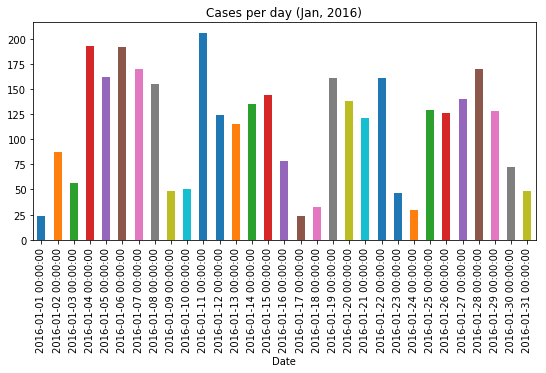

In [101]:
# View plot of number of cases per day
cases_per_day_jan16.plot(kind = 'bar', title = 'Cases per day (Jan, 2016)', figsize = (9,4))
plt.show()

In [9]:
# View plot of number of cases per day
#cases_per_day = df.groupby(by=[pd.TimeGrouper(freq='M')])['subject'].count()
#cases_per_day
#cases_per_day.plot(kind = 'bar', title = 'Cases per day', figsize=(20,5))
#plt.show()

In [46]:
# Could the reasons be consolidated?
df.groupby(['subject', 'reason'])['title'].count()

subject                  reason                         
Animal Related           Animal Control                     10478
Health / Environmental   Unhealthy Conditions                3788
Permits / Licensing      Commercial / Business Licensing      982
Property                 Commercial Property                  890
                         Construction Inspections             786
                         Private Property                   19782
                         Truth in Sale of Housing              20
                         Zoning                               208
Public Safety            Fire                                 559
                         Graffiti / Clean City               9806
                         Police                               362
Sidewalks                Complaints                          1955
                         Inspection                           672
                         Snow & Ice                          5698
Solid Waste & Recyc

In [113]:
# Could the titles be consolidated?
df.groupby(['reason', 'title'])['title'].count()

reason                           title                                      
Animal Control                   Animal Complaint - Livability                   8288
                                 Animal Complaint - Public Health                2190
Biking                           Abandoned/Illegally Parked Bicycle               720
                                 Bicycle Lane Issue                                13
                                 Bicycle Trail Improvement Request                  2
                                 Bike Lane Issue - Open311                        112
Bridges                          Bridge Complaint                                   7
Commercial / Business Licensing  Licensing Complaint                              982
Commercial Property              Commercial Structure Unsound                       7
                                 Commercial/Mixed Conditions Complaint            883
Complaints                       Sidewalk Obstruction Complaint

## Which type of cases from 2016 and 2017 are still open?

In [70]:
open_1617 = df[df['status']==1].groupby('title')['reason'].count()
open_1617

title
Bicycle Lane Issue                               1
Commercial Disability Zone                       3
Commercial Food Safety/Sanitation Complaint      8
Commercial/Mixed Conditions Complaint           10
Exterior Nuisance Complaint                     54
General Street Complaint                         1
Graffiti - Open311                              16
Graffiti complaint / reporting                  68
Homeless Encampment                              4
Land Pollution Complaint                         1
Noise Pollution Complaint                        8
Pothole                                          2
Pothole - Open311                                4
RHOD Conditions Complaint                       27
RHOD Tenant Conditions Complaint                41
Residential Conditions Complaint               201
Residential Conditions Complaint Tenant         55
Residential Disability Zone                      3
Street Light - New                               5
Street Light Outage      

In [74]:
open_16 = df[df['status']==1].loc['2016'].groupby('title')['reason'].count()
open_16

Series([], Name: reason, dtype: int64)

There are no open cases from 2016. This leads us to conclude that all cases are eventually closed. However, 32 different types of cases from 2017 are still open. These cases have been open for 7 or more months.

## Do different subjects remain open longer?
We will examine the number of days cases are open by subject. Do some subjects tend to remain open longer? Do some have a wider range and variability? How has this changed from 2016 to 2017?

In [111]:
df.groupby('subject')['days_open'].describe()

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
Animal Related,10478.0,0.571769,2.655160,0.0,0.0,0.0,0.0,58.0
Health / Environmental,3771.0,11.918324,40.890281,0.0,0.0,1.0,3.0,419.0
Permits / Licensing,982.0,2.393075,3.314976,0.0,0.0,1.0,4.0,25.0
Property,21276.0,24.179921,57.297202,0.0,2.0,5.0,15.0,549.0
Public Safety,10643.0,15.738701,22.017228,0.0,1.0,10.0,20.0,253.0
Sidewalks,8325.0,18.487087,24.328571,0.0,1.0,7.0,37.0,289.0
Solid Waste & Recycling,1628.0,3.275184,11.595697,0.0,0.0,1.0,3.0,273.0
Streets,11543.0,9.641514,23.940677,0.0,1.0,3.0,8.0,533.0
Utilities Related,1078.0,5.163265,9.479552,0.0,0.0,2.0,7.0,156.0


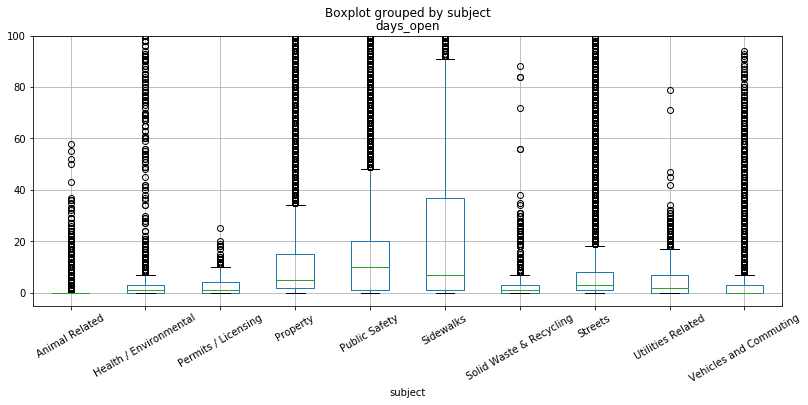

In [7]:
# Visualize boxplots, by subject, of number of days each case is open.
fig, ax = plt.subplots(figsize=(13,5))
plt.suptitle('')
df.boxplot(column=['days_open'], by='subject', ax=ax, rot=30)
#plt.yscale('log')
plt.ylim((-5,100))
plt.show()

* Every subject has a wide range of days until a case is closed. With data points spread from 0 to 549, the y-axis was scaled with the log function. This makes higher data points more visible. However, the 25th percentile is 0 for more than half the subjects, and isn't visible as it lies on the x-axis.
* The 25th to 75th percentile box for Animal Related cases lies entirely at 0. Only the non-zero outliers are visible. This subject has the most consistent close time, and has the 2nd shortest spread. Permits/Licensing has a slightly shorter overall spread.
* There aren't strong patterns correlating mean, spread, and density. 

### How have cases changed from year to year, by subject?

In [126]:
df.loc['2016'].groupby('subject')['days_open'].describe()

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
Animal Related,5292.0,0.649471,2.923997,0.0,0.0,0.0,0.0,55.0
Health / Environmental,1992.0,2.268574,12.722067,0.0,0.0,0.0,2.0,407.0
Permits / Licensing,445.0,1.874157,2.901131,0.0,0.0,1.0,3.0,25.0
Property,10998.0,14.202946,52.384527,0.0,1.0,3.0,7.0,549.0
Public Safety,4794.0,14.021277,17.811856,0.0,3.0,10.0,18.0,186.0
Sidewalks,4117.0,16.080641,26.412034,0.0,2.0,7.0,18.0,289.0
Solid Waste & Recycling,501.0,3.610778,13.236095,0.0,0.0,1.0,4.0,273.0
Streets,5865.0,9.977664,25.303061,0.0,0.0,3.0,8.0,533.0
Utilities Related,502.0,6.450199,8.847596,0.0,0.0,3.0,10.0,79.0


In [127]:
df.loc['2017'].groupby('subject')['days_open'].describe()

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
Animal Related,5186.0,0.492480,2.346963,0.0,0.0,0.0,0.0,58.0
Health / Environmental,1779.0,22.723440,56.061502,0.0,0.0,2.0,6.0,419.0
Permits / Licensing,537.0,2.823091,3.568151,0.0,0.0,2.0,4.0,19.0
Property,10278.0,34.855809,60.327113,0.0,2.0,11.0,31.0,373.0
Public Safety,5849.0,17.146350,24.853988,0.0,0.0,11.0,22.0,253.0
Sidewalks,4208.0,20.841492,21.849004,0.0,0.0,8.0,41.0,129.0
Solid Waste & Recycling,1127.0,3.125998,10.789777,0.0,0.0,1.0,2.0,131.0
Streets,5678.0,9.294294,22.443726,0.0,1.0,3.0,9.0,314.0
Utilities Related,576.0,4.041667,9.869320,0.0,0.0,2.0,5.0,156.0


In [63]:
subj_mean16 = df.loc['2016'].groupby('subject')['days_open'].mean()
subj_mean17 = df.loc['2017'].groupby('subject')['days_open'].mean()
subj_diff = subj_mean17 - subj_mean16
subj_diff

subject
Animal Related             -0.156991
Health / Environmental     20.454866
Permits / Licensing         0.948934
Property                   20.652863
Public Safety               3.125073
Sidewalks                   4.760851
Solid Waste & Recycling    -0.484780
Streets                    -0.683370
Utilities Related          -2.408533
Vehicles and Commuting     -0.204289
Name: days_open, dtype: float64

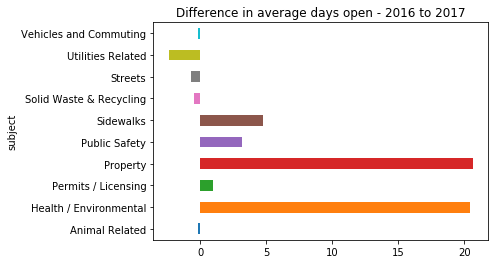

In [64]:
subj_diff.plot(kind = 'barh', title = 'Difference in average days open - 2016 to 2017')
plt.show()

* From 2016 to 2017, Vehicles and Communiting, Streets, Solid Waste & Recycling, Permits / Licensing, and Animal Related cases all had less than a 1 day changing in average (mean) close time.
* At the other end of the spectrum, Property or Health / Environmental cases increased by slightly over 20 days. 

### Property cases - What's driving the increase in average number of days these cases are open?
We will break these cases down into Reason and Title sub-categories. To identify the main drivers, we'll examine the number of cases and the average days open per sub-category.

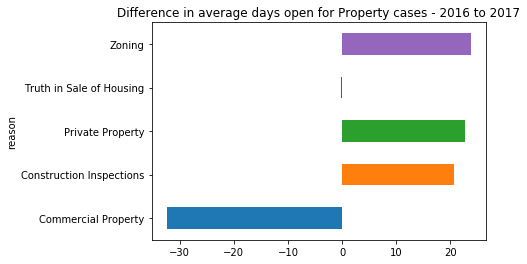

In [67]:
property_mean16 = df[df['subject']=='Property'].loc['2016'].groupby('reason')['days_open'].mean()
property_mean17 = df[df['subject']=='Property'].loc['2017'].groupby('reason')['days_open'].mean()
property_diff =  property_mean17 - property_mean16
property_diff.plot(kind = 'barh', title = 'Difference in average days open for Property cases - 2016 to 2017')
plt.show()

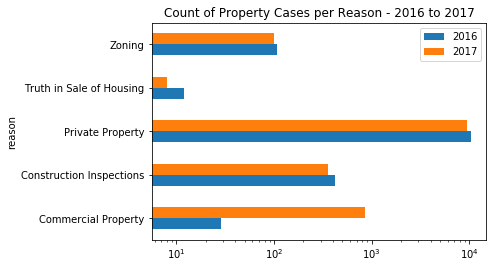

In [101]:
property_count16 = df[df['subject']=='Property'].loc['2016'].groupby('reason')['reason'].count()
property_count17 = df[df['subject']=='Property'].loc['2017'].groupby('reason')['reason'].count()
property_increase =  (property_count17 - property_count16)
property_1617= pd.concat([property_count16, property_count17], axis=1, sort=True)
property_1617.columns = ['2016', '2017']
property_1617.plot(kind = 'barh', title = 'Count of Property Cases per Reason - 2016 to 2017')
plt.xscale('log') #View as log scale due to the number of Private Property cases.
plt.show()

In [100]:
m= pd.concat([property_count16, property_count17, property_increase, property_mean16, property_mean17], axis=1, sort=True)
m.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
m

,2016_Count,2017_Count,Difference,2016_Mean,2017_Mean
reason,,,,,
Commercial Property,29,861,832,47.344828,14.977673
Construction Inspections,426,360,-66,8.171362,28.823529
Private Property,10424,9358,-1066,14.493573,37.111595
Truth in Sale of Housing,12,8,-4,0.916667,0.750000
Zoning,107,101,-6,2.411215,26.227723


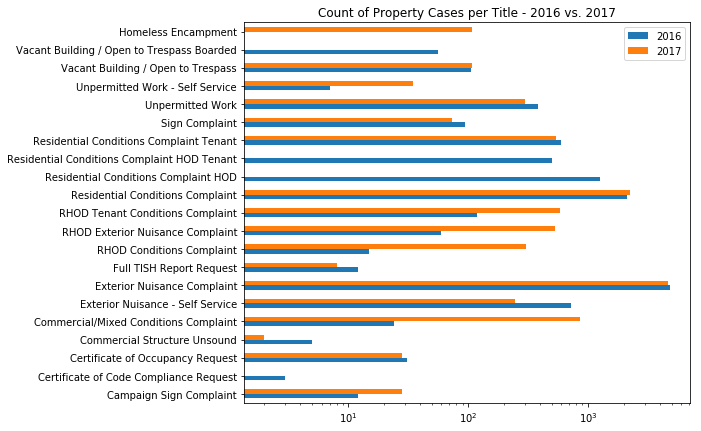

In [122]:
prop_title_mean16 = df[df['subject']=='Property'].loc['2016'].groupby('title')['days_open'].mean()
prop_title_mean17 = df[df['subject']=='Property'].loc['2017'].groupby('title')['days_open'].mean()
prop_title_count16 = df[df['subject']=='Property'].loc['2016'].groupby('title')['reason'].count()
prop_title_count17 = df[df['subject']=='Property'].loc['2017'].groupby('title')['reason'].count()
prop_title_increase =  (prop_title_count17 - prop_title_count16)
prop_title_1617= pd.concat([prop_title_count16, prop_title_count17], axis=1, sort=False)
prop_title_1617.columns = ['2016', '2017']
prop_title_1617.plot(kind = 'barh', title = 'Count of Property Cases per Title - 2016 vs. 2017', figsize = (8,7))
plt.xscale('log') #View as log scale due to the number of Exterior Nuisance cases.
plt.show()


In [123]:
t = pd.concat([prop_title_count16, prop_title_count17, prop_title_increase, prop_title_mean16, prop_title_mean17], axis=1, sort=False)
t.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
t

,2016_Count,2017_Count,Difference,2016_Mean,2017_Mean
Campaign Sign Complaint,12.0,28.0,16.0,2.750000,0.892857
Certificate of Code Compliance Request,3.0,NaN,NaN,0.333333,NaN
Certificate of Occupancy Request,31.0,28.0,-3.0,1.645161,1.714286
Commercial Structure Unsound,5.0,2.0,-3.0,1.000000,1.000000
Commercial/Mixed Conditions Complaint,24.0,859.0,835.0,57.000000,15.010601
Exterior Nuisance - Self Service,723.0,248.0,-475.0,2.975104,26.806452
Exterior Nuisance Complaint,4854.0,4682.0,-172.0,12.030696,43.912489
Full TISH Report Request,12.0,8.0,-4.0,0.916667,0.750000
RHOD Conditions Complaint,15.0,303.0,288.0,70.866667,30.721014
RHOD Exterior Nuisance Complaint,60.0,535.0,475.0,38.000000,8.323364


#### Property cases - The Private Property (Exterior Nuisance) complaints drive the category's increase in average days open.
There are over 10 times as many Private Property cases than any other Property sub-type. These cases overwhelmingly drive the Property group's metrics. Although the number of Private Property calls decrease by around 10% from 2016 to 2017, the average days open increase from 14.5 to 37.1 days. 

Drilling down further, we see that the Exterior Nuisance Complaints make up the largest portion of Private Property cases. Again, we see that these cases have decrease in volume, yet increased in average days open. These account for the Property category's average number of days open to increase by just over 20 days.

#### Adjusting for titles missing or changed from 2016 to 2017.
 - There are only 3 entries for "Certificate of Code Compliance Request" in 2016, none in 2017. We could remove those rows.
 - "RHOD Tenant Conditions Complaint" can be combined with "Residential Conditions Complaint HOD Tenant".
 - "RHOD Conditions Complaint" can be combined with "Residential Conditions Complaint HOD".
 - "Unpermitted Work" can be combined with "Unpermitted Work - Self Service"

### Health/Environmental cases - What's driving the increase in average number of days these cases are open?
We will break these cases down into Title sub-categories. To identify the main drivers, we'll examine the number of cases and the average days open per sub-category.

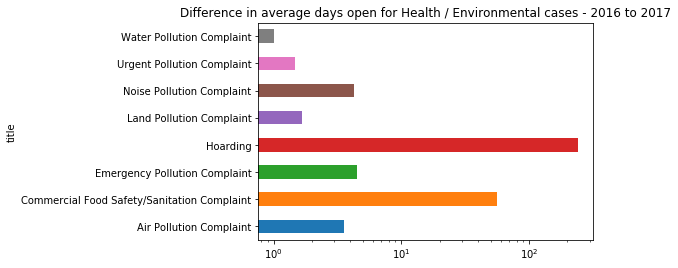

In [128]:
health_mean16 = df[df['subject']=='Health / Environmental'].loc['2016'].groupby('title')['days_open'].mean()
health_mean17 = df[df['subject']=='Health / Environmental'].loc['2017'].groupby('title')['days_open'].mean()
health_diff =  health_mean17 - health_mean16
health_diff.plot(kind = 'barh', title = 'Difference in average days open for Health / Environmental cases - 2016 to 2017')
plt.xscale('log') #View as log scale due to the increase in Hoarding cases.
plt.show()

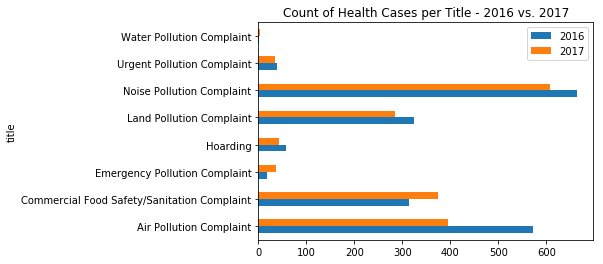

In [127]:
health_count16 = df[df['subject']=='Health / Environmental'].loc['2016'].groupby('title')['days_open'].count()
health_count17 = df[df['subject']=='Health / Environmental'].loc['2017'].groupby('title')['days_open'].count()
health_increase =  (health_count17 - health_count16)
health_1617= pd.concat([health_count16, health_count17], axis=1, sort=False)
health_1617.columns = ['2016', '2017']
health_1617.plot(kind = 'barh', title = 'Count of Health Cases per Title - 2016 vs. 2017')
#plt.xscale('log') #View as log scale due to the number of Noise and Air cases.
plt.show()

In [129]:
h = pd.concat([health_count16, health_count17, health_increase, health_mean16, health_mean17], axis=1, sort=False)
h.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
h

,2016_Count,2017_Count,Difference,2016_Mean,2017_Mean
title,,,,,
Air Pollution Complaint,573,395,-178,1.066318,4.658228
Commercial Food Safety/Sanitation Complaint,314,374,60,4.334395,60.478610
Emergency Pollution Complaint,19,37,18,0.736842,5.216216
Hoarding,58,43,-15,0.000000,241.697674
Land Pollution Complaint,324,284,-40,3.342593,5.010563
Noise Pollution Complaint,664,607,-57,2.162651,6.406919
Urgent Pollution Complaint,38,35,-3,0.368421,1.828571
Water Pollution Complaint,2,4,2,0.000000,1.000000


### What's up with Hoarding?
It took a very long time to resolve Hoarding cases in 2017. What's going on?

In [160]:
hoarding = df[df['title']=='Hoarding']
hoarding16 = df[df['title']=='Hoarding'].loc['2016']
hoarding17 = df[df['title']=='Hoarding'].loc['2017']
#hoarding16[['closed_date', 'days_open', 'x_geom', 'y_geom']]
hoarding17[['closed_date', 'days_open', 'x_geom', 'y_geom']]

,,closed_date,days_open,x_geom,y_geom
Date,Time,,,,
2017-01-10,03:17:29,2018-03-05 08:18:00,419.0,-93.256811,44.934139
2017-01-24,02:50:51,2018-03-05 08:20:00,405.0,-93.261635,44.893413
2017-01-31,07:11:36,2018-03-05 08:22:00,398.0,-93.312518,44.913303
2017-02-17,02:49:06,2018-03-05 08:23:00,381.0,-93.261993,44.944729
2017-02-22,08:23:59,2018-03-05 08:24:00,376.0,-93.290611,45.026667
2017-02-27,06:45:24,2018-03-05 08:25:00,371.0,-93.213363,44.953092
2017-03-09,02:55:35,2018-03-05 08:26:00,361.0,-93.208193,44.909013
2017-04-02,03:21:51,2018-03-05 08:30:00,337.0,-93.256887,44.955534
2017-04-04,06:12:36,2018-03-05 08:34:00,335.0,-93.237229,44.944955


#### Hoarding - These cases were handled differently each year. Where they ever resolved?
In 2016, every Hoarding case was closed the same day it was reported. Does this mean the calls were treated as informational and no action was taken to resolve them?

The opposite pattern in seen in 2017. One case reported on 2017-09-20 was closed after 6 days. However, the other 42 cases were all closed on the same day, 2018-03-05. We can confirm from the reported locations that these are distinct cases, not the same hoarder reported 42 times.  Perhaps the City tried a different method of handling these cases, and found they were still unable to resolve the cases in a significant way.

In [162]:
food = df[df['title']=='Commercial Food Safety/Sanitation Complaint']
food16 = df[df['title']=='Commercial Food Safety/Sanitation Complaint'].loc['2016']
food17 = df[df['title']=='Commercial Food Safety/Sanitation Complaint'].loc['2017']
#food16[['closed_date', 'days_open', 'x_geom', 'y_geom']]
food17[['closed_date', 'days_open', 'x_geom', 'y_geom']].sort_values('days_open', ascending=False)
#food17.describe()

closed_date  days_open     x_geom     y_geom
Date       Time                                                         
2017-07-18 06:02:04 2018-02-05 08:50:36      202.0 -93.271065  44.978339
           10:08:37 2018-02-05 08:49:40      201.0 -93.265840  44.973520
           12:39:27 2018-02-05 08:48:40      201.0 -93.277199  44.987026
2017-07-24 04:59:02 2018-02-05 08:47:36      196.0 -93.288239  44.900291
           07:59:26 2018-02-05 08:46:36      196.0 -93.254413  44.948365
2017-07-25 08:41:35 2018-02-05 08:44:35      195.0 -93.261916  44.980444
           09:15:52 2018-02-05 08:42:15      194.0 -93.277251  44.950929
2017-07-26 09:10:06 2018-02-05 08:40:43      193.0 -93.284618  44.999132
2017-07-29 03:28:04 2018-02-07 08:12:35      193.0 -93.263868  44.954638
2017-07-26 09:32:24 2018-02-05 08:37:58      193.0 -93.267480  44.971585
           09:22:56 2018-02-05 08:39:23      193.0 -93.275411  44.974288
2017-07-27 04:20:44 2018-02-05 08:36:02      193.0 -93.303249  44.981207
2017-07-28 11:18:08 2018-02-05 08:33:58      191.0 -93.251765  44.934123
2017-07-31 09:03:14 2018-02-05 07:20:56      188.0 -93.296185  44.957338
2017-08-01 09:36:24 2018-02-05 06:57:48      187.0 -93.232754  44.934119
2017-08-03 03:42:20 2018-02-05 06:52:48      186.0 -93.278599  44.919629
2017-08-02 08:42:20 2018-02-05 06:54:32      186.0 -93.277904  44.951451
2017-08-04 10:59:20 2018-02-05 06:51:49      184.0 -93.288675  44.955542
2017-08-07 10:28:22 2018-02-05 06:50:39      181.0 -93.293188  44.949204
2017-08-08 08:06:55 2018-02-05 06:49:15      180.0 -93.310173  45.020465
2017-05-30 04:12:39 2017-11-27 03:40:07      180.0 -93.287364  45.040324
2017-08-09 07:53:43 2018-02-05 06:48:03      179.0 -93.277254  44.951941
           08:56:11 2018-02-05 06:47:03      179.0 -93.222852  44.911251
2017-08-11 09:56:04 2018-02-05 06:45:59      177.0 -93.294115  44.998281
           11:21:48 2018-02-05 06:44:47      177.0 -93.241433  44.981458
2017-08-12 10:45:15 2018-02-05 06:41:34      176.0 -93.260672  44.971981
2017-08-13 10:33:26 2018-02-05 06:40:34      175.0 -93.267384  44.966155
2017-02-27 09:33:05 2017-08-22 03:50:14      175.0 -93.289522  44.997406
2017-06-05 10:57:24 2017-11-27 03:40:26      174.0 -93.291816  44.999148
2017-02-28 08:40:15 2017-08-22 03:52:07      174.0 -93.227903  44.973661
...                                 ...        ...        ...        ...
2017-03-28 12:23:09 2017-03-30 09:02:27        1.0 -93.232617  44.912589
2017-10-04 10:17:57 2017-10-06 04:32:03        1.0 -93.284618  44.999132
2017-04-03 04:46:00 2017-04-04 10:27:09        1.0 -93.272119  44.963952
2017-03-29 08:41:53 2017-03-30 10:20:17        1.0 -93.294876  44.999158
2017-10-16 04:19:38 2017-10-17 05:10:08        1.0 -93.308202  45.035451
2017-10-31 10:08:21 2017-11-01 06:09:42        0.0 -93.289522  44.997406
2017-02-08 09:03:13 2017-02-09 02:38:45        0.0 -93.231722  44.977584
2017-03-01 03:28:38 2017-03-02 03:12:30        0.0 -93.278392  45.013106
2017-06-05 08:29:30 2017-06-06 03:58:28        0.0 -93.239718  44.935019
2017-12-28 03:54:08 2017-12-28 09:31:25        0.0 -93.235923  44.965394
2017-10-30 06:16:35 2017-10-31 05:54:13        0.0 -93.289903  44.965391
2017-06-01 11:20:53 2017-06-02 08:22:00        0.0 -93.266761  44.969355
2017-02-08 09:02:01 2017-02-09 02:37:53        0.0 -93.230646  44.977798
2017-10-25 06:40:24 2017-10-26 05:48:40        0.0 -93.322806  44.948416
2017-10-05 07:07:07 2017-10-05 10:23:40        0.0 -93.260125  44.949223
2017-08-28 07:49:08 2017-08-29 05:01:23        0.0 -93.256954  44.948363
2017-01-20 05:33:43 2017-01-20 06:07:54        0.0 -93.277197  44.965219
2017-09-29 02:36:45 2017-09-29 03:34:13        0.0 -93.277478  44.894257
2017-11-21 07:38:58 2017-11-21 08:42:00        0.0 -93.273116  44.981648
2017-09-28 11:06:10 2017-09-29 09:09:01        0.0 -93.301896  45.008694
2017-09-06 04:46:30 2017-09-06 05:48:08        0.0 -93.293673  44.948911
2017-07-13 03:05:05 2017-07-13 08:47:14        0.0 -93.258144  44.917901
2017-08-27 09

## Change in case volume by subject

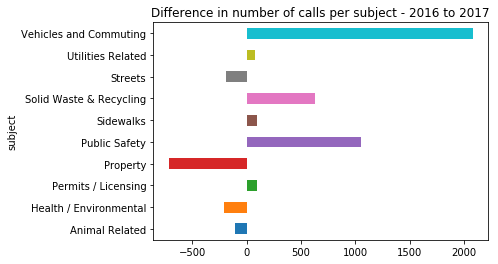

In [163]:
subj_count16 = df.loc['2016'].groupby('subject')['days_open'].count()
subj_count17 = df.loc['2017'].groupby('subject')['days_open'].count()
subj_diff_count = subj_count17 - subj_count16
subj_diff_count.plot(kind = 'barh', title = 'Difference in number of calls per subject - 2016 to 2017')
plt.show()

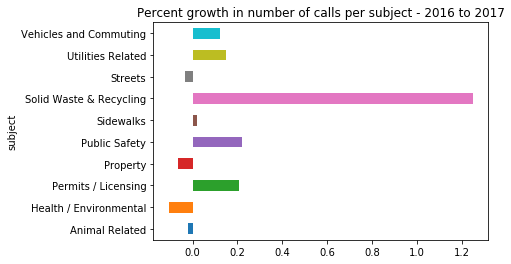

In [148]:
subj_count16 = df.loc['2016'].groupby('subject')['days_open'].count()
subj_count17 = df.loc['2017'].groupby('subject')['days_open'].count()
subj_diff_percent = (subj_count17 - subj_count16)/(subj_count16)
subj_diff_percent.plot(kind = 'barh', title = 'Percent growth in number of calls per subject - 2016 to 2017')
plt.show()

### Solid Waste and Recycling case volume increased by over 120%

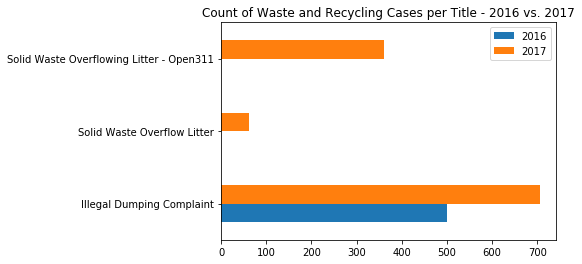

In [164]:
waste_count16 = df[df['subject']=='Solid Waste & Recycling'].loc['2016'].groupby('title')['days_open'].count()
waste_count17 = df[df['subject']=='Solid Waste & Recycling'].loc['2017'].groupby('title')['days_open'].count()
waste_increase =  (health_count17 - health_count16)
waste_1617= pd.concat([waste_count16, waste_count17], axis=1, sort=False)
waste_1617.columns = ['2016', '2017']
waste_1617.plot(kind = 'barh', title = 'Count of Waste and Recycling Cases per Title - 2016 vs. 2017')
#plt.xscale('log') #View as log scale due to the number of Noise and Air cases.
plt.show()

#### Solid Waste and Recycling - Additional categories, Lots of overflowing trash
There was higher volume in every Solid Waste sub-category. In 2017, new case titles were added to report overflowing waste containers (ex. dumpster or public trash bin). Complaints could be filed by phone or via the Open311 app.

In [ ]:
## geopandas, leaflet, open streetmap api

In [ ]:
df.groupby(by=[b.index.month, b.index.year])